1. Load a cv config with all experiment parameters
2. Load the corresponding data, 
3. create a train and validation generator with the given parameters, exclusive the augmentation parameters
4. reconstruct the model with the given parameters, (we have custom loss functions, simple model.load() will not work)
5. load and apply the corresponding weights (with respect to the distributed training strategy)
6. predict the targt vectors with the train and val generators (make sure that we change the batchsize to 1, and avoid shuffle so that we get all files)
7. unstack each predictions and crop it by the length of the stacked gt mask
8. threshold/argmax each predicted onehot-vector
9. write the gt and predictions as numpy into the corresponding experiment folder (gt with gaussian, or without?, Do we save the onehot or the indicies?)

In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config

# import external libs
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
import pandas as pd
import numpy as np
from ipyfilechooser import FileChooser


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


# Load a config into the global namespace

In [2]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'exp/'), '')
display(exp_config_chooser)
@interact_manual
def load_config():

    global exp_config_chooser, config
    """
    load an experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        print('no config chooser found')

    # load the experiment config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp', filename='', title='HTML(value='', layout=Layout(displ…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the corresponding file names for this fold

In [3]:
# load ACDC files
x_train_sax = sorted(glob.glob('/mnt/ssd/data/acdc/original/all/*/*4d.nii.gz'))
x_val_sax = x_train_sax
info(len(x_val_sax))

2021-05-20 13:22:45,354 INFO 100


In [6]:
# Load SAX volumes
from src.data.Dataset import get_trainings_files
# cluster to local data mapping
#DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax'
#DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
#config['DF_META'] = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
"""x_train_sax, y_train_sax, x_val_sax, y_val_sax = get_trainings_files(data_path=DATA_PATH_SAX,
                                                                     path_to_folds_df=DF_FOLDS,
                                                                     fold=FOLD)"""
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

NameError: name 'y_train_sax' is not defined

# Create the same train and val generators as used for the training

Make sure that:
- no shuffle
- no augmentation (classic and temporal)
- batchsize equal 1

In [23]:
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
config['SHUFFLE'] = False
config['AUGMENT'] = False
config['AUGMENT_PHASES'] = False
config['AUGMENT_TEMP'] = False
config['BATCHSIZE'] = 1
config['HIST_MATCHING'] = False
#batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
# create another config for the validation data, for the case of different evaluation
val_config = config.copy()
#val_config['AUGMENT'] = False
#val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax, config=val_config)

2021-05-20 13:37:51,881 INFO Create DataGenerator
2021-05-20 13:37:51,883 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment: False 
 Thread workers: 8
2021-05-20 13:37:51,883 INFO No augmentation
2021-05-20 13:37:51,884 INFO Temporal phase augmentation: 
False
Repeat volume: 
True
2021-05-20 13:37:51,884 INFO params of generator:
2021-05-20 13:37:51,884 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'MinMax'), ('AUGMENT', False), ('SHUFFLE', False), ('RESAMPLE', True), ('SPACING', [8, 3, 3]), ('SEED', 42), ('DIM', [8, 64, 64]), ('BATCHSIZE', 1), ('MASK_VALUES', [0, 1, 2, 3]), ('N_CLASSES', 4), ('MAX_WORKERS', 8), ('AUGMENT_PHASES', False), ('T_SHAPE', 36), ('T_SPACING', 55), ('PHASES', 5), ('REPEAT', True), ('TARGET_SMOOTHING', True), ('SMOOTHING_KERNEL_SIZE', 10), ('SMOOTHING_UPPER_BORDER', 5), ('SMOOTHING_WEIGHT_CORRECT', 20), ('SIGM

In [18]:
# visualise one batch
generator = validation_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator)-1, 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))

interactive(children=(IntSlider(value=5, description='batch', max=11), IntSlider(value=3, description='im', ma…

# Load the model, load and set the corresponding weights

In [19]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)
model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
logging.info('loaded model weights as h5 file')

2021-05-20 13:35:54,382 INFO loaded model weights as h5 file


Shape after the temporal encoder
(None, 36, 8, 4, 4, 320)
Shape after GAP
(None, 36, 320)
Shape after Bi-LSTM layer
(None, 36, 320)
Shape after final conv layer
(None, 36, 5)
msecce
[<src.utils.Metrics.MSE object at 0x7f6f46d730a0>, <src.utils.Metrics.CCE object at 0x7f6f46d944f0>]
added loss: msecce


# Predict on the validation split

In [24]:
# predict on the validation generator
preds = model.predict(validation_generator)
logging.info(preds.shape)

2021-05-20 13:38:27,422 INFO (100, 2, 36, 5)


# Get all GT vectors

In [25]:
# get all ground truth vectors
gts = np.stack([np.squeeze(y) for x, y in validation_generator])
logging.info(gts.shape)

2021-05-20 13:38:53,820 INFO (100, 2, 36, 5)


# Save gt and pred into the experiment folder

In [26]:
pred_path = os.path.join(config['EXP_PATH'], 'acdc_pred')
ensure_dir(pred_path)
pred_filename = os.path.join(pred_path, 'gtpred_fold{}.npy'.format(config['FOLD']))
np.save(pred_filename, np.stack([gts, preds], axis=0))
logging.info('saved as: \n{} \ndone!'.format(pred_filename))

2021-05-20 13:38:53,840 INFO saved as: 
exp/temp/relu_mse_comb_cce/2021-05-20_11_12/acdc_pred/gtpred_fold0.npy 
done!


In [5]:
search_str = '**/**/config/config.json'
glob.glob(os.path.join('/mnt/ssd/git/dynamic-cmr-models/exp/local/miccai_baseline',search_str))

['/mnt/ssd/git/dynamic-cmr-models/exp/local/miccai_baseline/miccai_baseline_f0/2021-05-10_12_03/config/config.json',
 '/mnt/ssd/git/dynamic-cmr-models/exp/local/miccai_baseline/miccai_baseline_f1/2021-05-10_12_54/config/config.json',
 '/mnt/ssd/git/dynamic-cmr-models/exp/local/miccai_baseline/miccai_baseline_f2/2021-05-10_13_37/config/config.json',
 '/mnt/ssd/git/dynamic-cmr-models/exp/local/miccai_baseline/miccai_baseline_f3/2021-05-10_14_21/config/config.json']

# Load the gts, predictions testwise

In [27]:
temp = np.load(pred_filename)
print(temp.shape)
gts, preds = np.split(temp,indices_or_sections=2)
gts, preds = gts[0], preds[0]
print(gts.shape)
print(preds.shape)

(2, 100, 2, 36, 5)
(100, 2, 36, 5)
(100, 2, 36, 5)


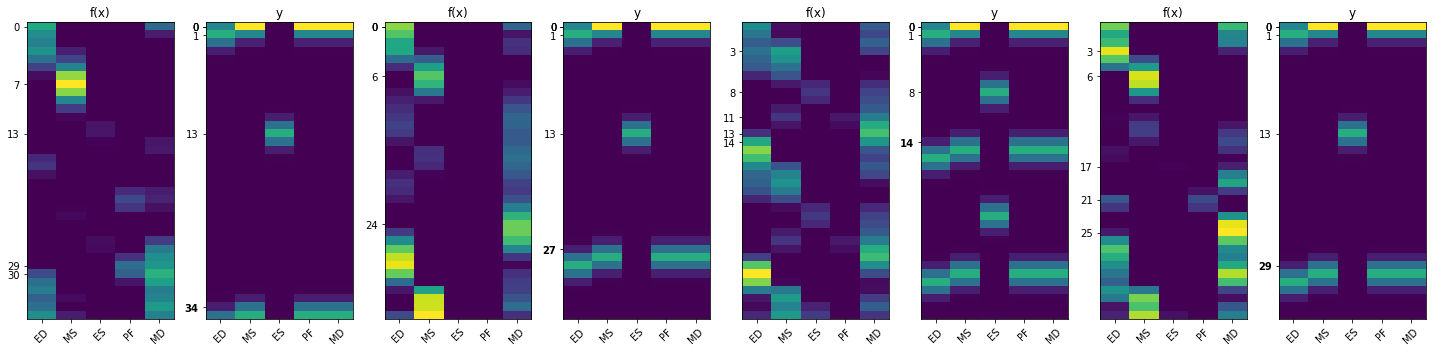

In [28]:
from src.visualization.Visualize import show_phases
idx = 8
_ = show_phases(gts[idx:idx+4], preds[idx:idx+4])

In [29]:
from src.utils.Metrics import meandiff
res = meandiff(gts,preds, apply_sum=False, apply_average=False)

In [30]:
res.shape

TensorShape([100, 5])

In [31]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
df = pd.DataFrame(res.numpy(), columns=phases)
df.shape

(100, 5)

In [13]:
df

,ED,MS,ES,PF,MD
0,0,0,2,1,1
1,1,1,0,2,2
2,1,1,2,0,1
3,1,1,1,1,1
4,0,0,1,0,0
...,...,...,...,...,...
64,1,2,3,1,0
65,1,1,1,0,2
66,1,1,1,0,0
67,2,0,0,1,1
